![](images/2025-07-28-the-horse-in-motion-ffmpeg-gotchas-part-1.jpg)

## Introduction

I recently worked on a project that involved images, videos, and audio—transforming and stitching them together into a cohesive experience. I started with [MoviePy](https://zulko.github.io/moviepy/), but it turned out to be too slow for most of the heavy lifting. So I switched to [FFmpeg](https://ffmpeg.org/) and was immediately impressed by its speed. That said, working with FFmpeg came with its own set of challenges.

This post is the first in a series where I'll walk through some of the gotchas I ran into while working with FFmpeg. The project itself involved taking real estate images and turning them into virtual property tours using generative AI. Each video also had embedded narration, giving the feel of a live guided tour. For the generative part, I used external services — [RunwayML](https://runwayml.com/) for generating video segments and [OpenAI](https://openai.com/) for voiceovers. FFmpeg was the glue that stitched everything together into a final polished video. The service was deployed as an API where users could upload property images, and I used [AWS Lambda](https://docs.aws.amazon.com/lambda/latest/dg/welcome.html) and [Step Functions](https://docs.aws.amazon.com/step-functions/latest/dg/welcome.html) for code execution and orchestration.

To simulate some of the challenges I faced, I decided to recreate the famous "[The Horse in Motion](https://en.wikipedia.org/wiki/The_Horse_in_Motion)” video. Originally created by Eadweard Muybridge in 1878, it's a landmark in the history of motion pictures and has been widely studied and referenced.

In this first part, we'll create the video using Google Colab. We'll start with still frames from the original motion study, convert them into a video, and overlay some text using FFmpeg's `drawtext` filter. In upcoming posts, we'll try running all of this within an AWS Lambda function—and work through the issues that pop up along the way.

### Environment Details

You can access and run this Jupyter Notebook from the GitHub repository on this link: [2025-07-28-the-horse-in-motion-ffmpeg-gotchas-part-1.ipynb]()

This notebook was created and tested in [Google Colab](https://colab.research.google.com/). The great thing about Google Colab is that it comes with FFmpeg pre-installed, so you can run the code without any additional setup. You can run it in any Jupyter environment, but you might need to install FFmpeg first.

Let's start by checking the installed FFmpeg version.

In [1]:
!ffmpeg -version

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-l

We'll also install and use the [watermark library](https://github.com/rasbt/watermark). It's an `IPython` magic extension that's incredibly useful for printing environment details like Python versions, library versions, and hardware information. It's a great practice for reproducibility.

In [2]:
%%capture
!pip install watermark

In [ ]:
%load_ext watermark
%watermark -v -m -p watermark,matplotlib,PIL

Python implementation: CPython
Python version       : 3.11.13
IPython version      : 7.34.0

watermark : 2.5.0
matplotlib: 3.10.0
PIL       : 11.3.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.123+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



## A Quick Intro to FFmpeg

Before we dive in, *what exactly is FFmpeg*?

Think of FFmpeg as the **Swiss Army knife for multimedia**. It’s not a single program you click on, but a powerful command-line framework that can decode, encode, transcode, mux, demux, stream, filter, and play virtually any media format created. It's the silent engine behind many famous applications like VLC, Plex, and even YouTube, which uses it for video processing.

Its power comes from its command-line nature. You string together a series of flags and options to tell it exactly what you want to do. This can feel intimidating at first (the manual is famously long!), but once you grasp the basic pattern, you unlock a world of possibilities for automating video and audio manipulation.

## Download the video frames

First, we need the raw materials: the individual frames of "The Horse in Motion." I've hosted them on a public GitHub repository. The following Python code will create a directory called `video_frames` and download the 15 images into it.

In [5]:
import os
import requests

# Create the output directory if it doesn't exist
output_dir = "video_frames"
os.makedirs(output_dir, exist_ok=True)

# Base URL for the raw images
base_url = "https://raw.githubusercontent.com/hassaanbinaslam/myblog/5c15e72dde03112c5c8dea177bfed7c835aca399/posts/images/2025-07-28-the-horse-in-motion-ffmpeg-gotchas-part-1/video_frames"

# Download each frame
for i in range(1, 16):
    frame_number = str(i).zfill(2)  # Pad with zero if needed (e.g., 01, 02)
    image_url = f"{base_url}/frame{frame_number}.png"
    response = requests.get(image_url)
    if response.status_code == 200:
        with open(os.path.join(output_dir, f"frame{frame_number}.png"), "wb") as f:
            f.write(response.content)
        print(f"Downloaded frame{frame_number}.png")
    else:
        print(f"Failed to download frame{frame_number}.png")

print("\nListing downloaded files:")
!ls video_frames

Downloaded frame01.png
Downloaded frame02.png
Downloaded frame03.png
Downloaded frame04.png
Downloaded frame05.png
Downloaded frame06.png
Downloaded frame07.png
Downloaded frame08.png
Downloaded frame09.png
Downloaded frame10.png
Downloaded frame11.png
Downloaded frame12.png
Downloaded frame13.png
Downloaded frame14.png
Downloaded frame15.png

Listing downloaded files:
frame01.png  frame04.png  frame07.png  frame10.png  frame13.png
frame02.png  frame05.png  frame08.png  frame11.png  frame14.png
frame03.png  frame06.png  frame09.png  frame12.png  frame15.png


Before we stitch them into a video, let's use `matplotlib` and `Pillow` to have a look at the frames we just downloaded. This helps confirm everything looks correct.

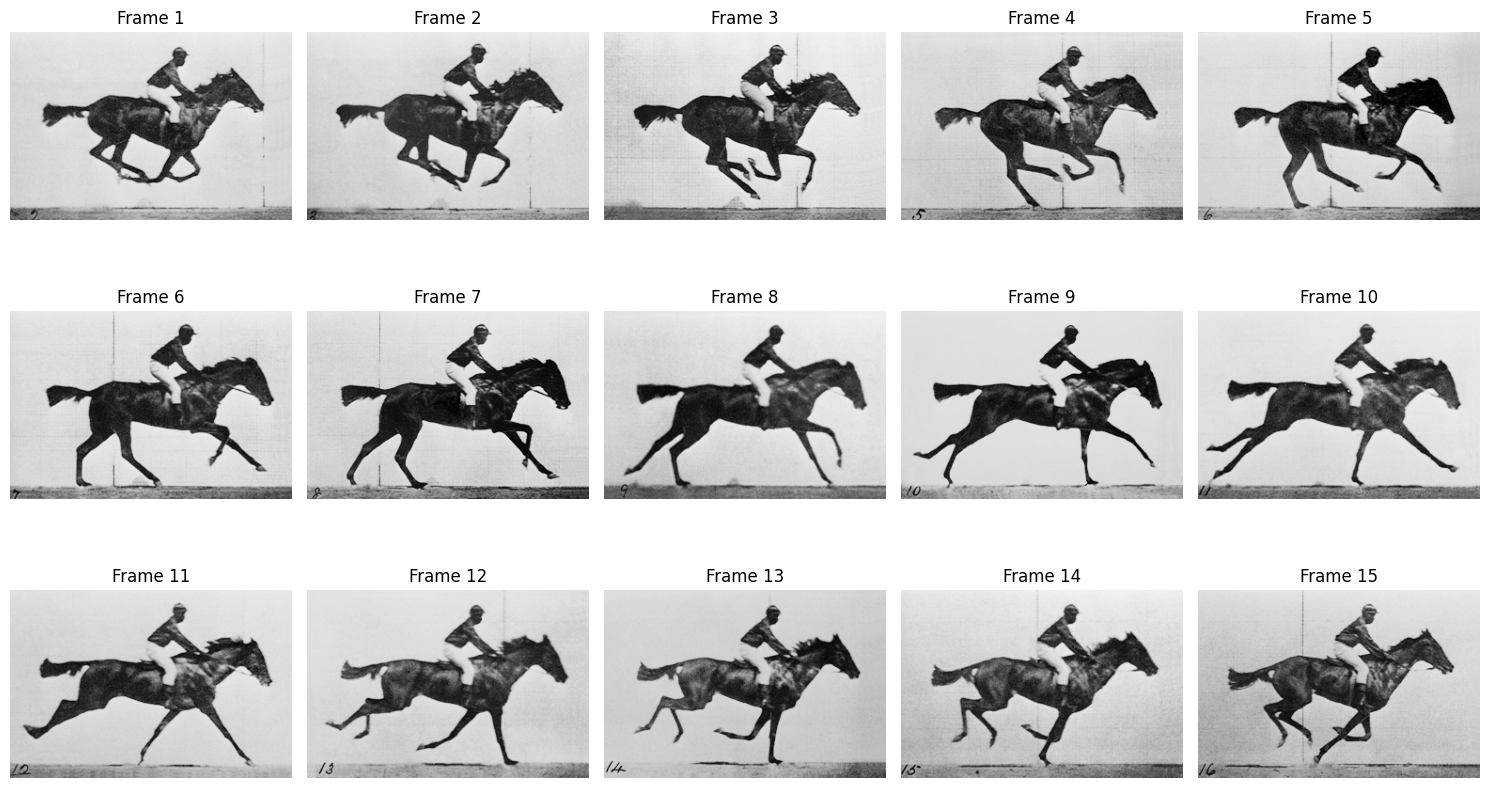

In [6]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Get the list of image files
image_files = sorted([os.path.join("video_frames", f) for f in os.listdir("video_frames") if f.endswith(".png")])

# Create a grid of subplots
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

# Display each image
for i, (img_path, ax) in enumerate(zip(image_files, axes)):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"Frame {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Creating the Video with FFmpeg

Now for the main event. We'll use a single FFmpeg command to take our 15 separate `png` images and turn them into a looping `mp4` video file with text overlaid.

In [7]:
!ffmpeg \
-stream_loop -1 -framerate 1.5 -i video_frames/frame%02d.png \
-vf "drawtext=fontfile=/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf:text='The Horse in Motion and FFmpeg Gotchas':fontcolor=white:fontsize=14:box=1:boxcolor=black@0.8:boxborderw=5:x=(w-text_w)/2:y=(h-text_h)/2:enable='between(t,0,10)'" \
-c:v libx264 -r 30 -pix_fmt yuv420p -t 40 \
output_with_text.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Let's view the output video.

Video link: [output_with_text.mp4](https://github.com/hassaanbinaslam/myblog/blob/a723a8c7175727f7d7b604695ab31b5035234832/posts/images/2025-07-28-the-horse-in-motion-ffmpeg-gotchas-part-1/output_with_text.mp4)

{{< video https://youtu.be/lN_uRDTSYQs 
    title='The Horse in Motion and FFmpeg Gotchas Part 1'
>}}

### Understanding the FFmpeg Command

That command looks complicated, so let's break it down flag by flag. This is the key to understanding FFmpeg.

*   `!ffmpeg`: The `!` tells our Jupyter Notebook to execute this as a shell command. `ffmpeg` is the program we're running.
*   `-stream_loop -1`: This is an input option that tells FFmpeg to loop the input stream (`-1` means loop indefinitely). Since we only have 15 frames, this allows us to create a video longer than just a few seconds.
*   `-framerate 1.5`: This sets the **input framerate**. It tells FFmpeg to treat our sequence of images as a video playing at a very slow 1.5 frames per second, giving it that classic, choppy, old-timey feel.
*   `-i video_frames/frame%02d.png`: This is our input file. The `%02d` is a pattern that tells FFmpeg to look for image files named `frame01.png`, `frame02.png`, `frame03.png`, and so on.
*   `-vf "..."`: This stands for **Video Filter**. It's where we apply transformations to the video. We're using the `drawtext` filter here to burn text onto the video frames. We'll look at this more closely in a moment.
*   `-c:v libx264`: This sets the **video codec**. `-c:v` means "codec for video," and `libx264` is a very popular, high-quality, and widely compatible H.264 video encoder.
*   `-r 30`: This sets the **output framerate** to 30 frames per second. This is a common gotcha! We read the input at 1.5 fps but write the output at 30 fps. FFmpeg handles this by duplicating frames to fill in the gaps, resulting in a smooth video file that plays correctly everywhere.
*   `-pix_fmt yuv420p`: This sets the **pixel format**. Don't worry too much about the details, but `yuv420p` is the most common format for web video and ensures our MP4 is compatible with the widest range of players and browsers.
*   `-t 40`: This sets the total **duration** of the output video to 40 seconds.
*   `output_with_text.mp4`: This is simply the name of our output file.

## Inspecting the Output with ffprobe

We've created our video, but how do we know it worked correctly? Did FFmpeg actually apply the settings we asked for? This is where `ffprobe`, FFmpeg's companion tool for media analysis, comes in.

If `ffmpeg` is the factory that builds the car, `ffprobe` is the inspector who reads the spec sheet to make sure it was built correctly. It doesn't change the file; it just tells you everything about it.

Let's run it on our new video to inspect its properties. We'll ask for the video stream information in a clean, readable format.

In [10]:
!ffprobe -v quiet -print_format default=noprint_wrappers=1 -show_format -show_streams /content/output_with_text.mp4

index=0
codec_name=h264
codec_long_name=H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10
profile=High
codec_type=video
codec_tag_string=avc1
codec_tag=0x31637661
width=300
height=200
coded_width=300
coded_height=200
closed_captions=0
has_b_frames=2
sample_aspect_ratio=N/A
display_aspect_ratio=N/A
pix_fmt=yuv420p
level=13
color_range=unknown
color_space=unknown
color_transfer=unknown
color_primaries=unknown
chroma_location=left
field_order=unknown
refs=1
is_avc=true
nal_length_size=4
id=N/A
r_frame_rate=30/1
avg_frame_rate=30/1
time_base=1/15360
start_pts=0
start_time=0.000000
duration_ts=613888
duration=39.966667
bit_rate=114005
max_bit_rate=N/A
bits_per_raw_sample=8
nb_frames=1199
nb_read_frames=N/A
nb_read_packets=N/A
DISPOSITION:default=1
DISPOSITION:dub=0
DISPOSITION:original=0
DISPOSITION:comment=0
DISPOSITION:lyrics=0
DISPOSITION:karaoke=0
DISPOSITION:forced=0
DISPOSITION:hearing_impaired=0
DISPOSITION:visual_impaired=0
DISPOSITION:clean_effects=0
DISPOSITION:attached_pic=0
DISPOSITION:

Let's break down the `ffprobe` command and see how the output confirms our `ffmpeg` settings:

*   `-v quiet`: This tells `ffprobe` to be quiet and not print its usual banner and logging info.
*   `-print_format default=noprint_wrappers=1`: This formats the output as simple `key=value` lines, which is much easier to read than the default JSON.
*   `-show_streams`: This is the core instruction, telling `ffprobe` to show information about the media streams (in this case, our single video stream).

Now, let's look at the output. We can see our `ffmpeg` flags reflected perfectly:

*   `codec_name=h264`: Confirms we used the `libx264` encoder.
*   `width=300`, `height=200`: Confirms the resolution is correct.
*   `pix_fmt=yuv420p`: Confirms our pixel format for compatibility.
*   `avg_frame_rate=30/1`: Confirms our output framerate is 30 fps, just as we set with `-r 30`.
*   `duration=39.966667`: Confirms the video duration is approximately 40 seconds, matching our `-t 40` flag.

Using `ffprobe` is a crucial step in any FFmpeg workflow. It gives you confidence that your command worked as expected and is the first tool you should reach for when a video isn't behaving correctly.

## A Word on Codecs

We used `-c:v libx264`, but what is a "codec"? The word stands for **Co**der-**Dec**oder. Think of it like a language for video.

*   An **encoder** compresses and writes the video file in a specific language (like H.264).
*   A **decoder** reads the file and plays it back, speaking the same language.

Your FFmpeg build comes with a set of built-in codecs. Not every build has every codec, which can be a huge gotcha in different environments. You can see all the codecs your current FFmpeg build supports with this command:

```bash
!ffmpeg -codecs
```

The output is long, but you'll see lines like this:

```
...
 DEV.LS h264          H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10 (decoders: h264 h264_qsv h264_cuvid ) (encoders: libx264 libx264rgb h264_nvenc h264_omx h264_qsv )
...
```
The letters at the beginning tell you what FFmpeg can do with this format. `D` means decoding is supported, `E` means encoding is supported, and `V` means it's a video codec. Our `libx264` is listed as an available encoder.

In [8]:
!ffmpeg -codecs

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

## The Power of Filters and Build Configuration

The `-vf` (video filter) flag is where much of FFmpeg's magic happens. We used `drawtext`, but there are filters for scaling, cropping, rotating, color correction, and hundreds of other tasks.

A critical gotcha with filters is that they often depend on external libraries that must be included when FFmpeg is compiled. The `drawtext` filter, for instance, needs a font rendering library called `freetype`.

How can you know if your build supports it? You can check the build configuration:

`ffmpeg -buildconf`

In the output, you'll see a long list of `--enable-` flags. If you see `--enable-libfreetype`, you know the `drawtext` filter should work. This becomes extremely important when you're building FFmpeg for a minimal environment like Docker or AWS Lambda, where you might not have these libraries by default.

In [9]:
!ffmpeg -buildconf

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

## Conclusion and Next Steps

In this post, we successfully took a sequence of still images and, with a single command, turned them into a looping, annotated video. We've demystified some of the most common FFmpeg flags and explored the core concepts of codecs and filters.

Everything worked smoothly here in Google Colab, which provides a feature-rich FFmpeg build out of the box. But what happens when we move to a more constrained, production-like environment?

In **Part 2**, we’ll take this exact process and try to run it inside an **AWS Lambda function**. We'll quickly run into new gotchas related to missing libraries, incorrect file paths, and the challenge of packaging the FFmpeg binary itself. Stay tuned